In [3]:
import imageio
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy.signal as sig
import scipy.optimize as optimize
%matplotlib inline

In [4]:
def crop_vertical(image, toprows, botrows):
    return image[toprows:len(image)-botrows]

In [5]:
# image is numpy array 
def rotate_90(image):
    return np.rot90(image, k=3)

In [6]:
def mean_max_min(row):
    center = (row.max() + row.min()) / 2
    flipped_row = (-1*(row - center)) + center
    max_ins = sig.find_peaks(row)
    min_ins = sig.find_peaks(flipped_row)
    mean_max = np.nanmean(row[max_ins[0]])
    mean_min = np.nanmean(row[min_ins[0]])
    return (mean_max, mean_min)

In [7]:
def contrast_ratio(max_val, min_val):
    return (max_val - min_val) / (max_val + min_val)

In [8]:
def calc_dof_len(in_dist, mag, pixel_size):
    return (in_dist * pixel_size) / mag

In [9]:
def median_filter(row, k=5):
    if k % 2 == 0:
        k += 1
    return sig.medfilt(row, k)

In [10]:
def calc_DOF(image, threshold, mag, pixel_size, bin_size, savefig, save_name):
    im = imageio.imread(image, as_gray=True)
    orig = im
    crop_pixels = 1
    im = rotate_90(im)
    contrast_ratios = np.array([contrast_ratio(mean_max_min(row)[0], 
                                               mean_max_min(row)[1]) for row in im])
    smooth_ratios = median_filter(contrast_ratios, bin_size)
    center = (contrast_ratios.max() + contrast_ratios.min()) / 2
    max_index = np.nanargmax(contrast_ratios)
    light = np.sum(im[max_index])
    max_ratio = contrast_ratios[max_index]   
    min_ins = np.argwhere(contrast_ratios < threshold*max_ratio)
    # get the first indices where the threshold is crossed 
    min_ins = np.array([np.amax(np.where(min_ins<max_index, min_ins, -np.inf)), 
                            np.amin(np.where(min_ins>max_index, min_ins, np.inf))])
    plt.figure(dpi=250)
    plt.title(image)
    plt.imshow(orig, cmap='gray')
    plt.axvline(max_index, color='y', linewidth=1)
    plt.plot((smooth_ratios*-1*orig.shape[0])+orig.shape[0], color='r')
    plt.vlines(min_ins, 0, orig.shape[0], color='b', linewidth=1)
    if savefig:
        plt.savefig(save_name, format='pdf', dpi=150)
    plt.show()
    plt.figure(dpi=100)
    plt.ylabel("contrast ratio")
    plt.xlabel("x pixel location")
    plt.title('Contrast ratio ' + str(image))
    plt.plot(smooth_ratios, color='r')
    plt.show()
    pix_len = abs(min_ins[1] - min_ins[0])
    dof = calc_dof_len(pix_len, mag, pixel_size)
    print("DOF in mm: ", dof)
    return light, max_ratio

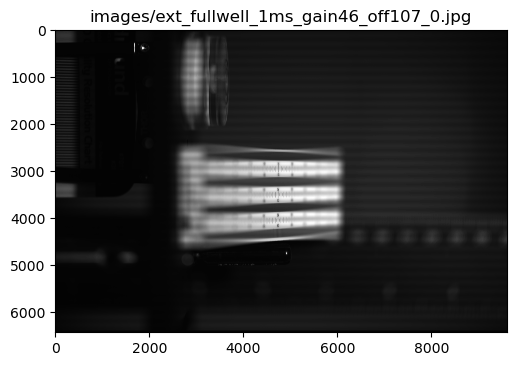

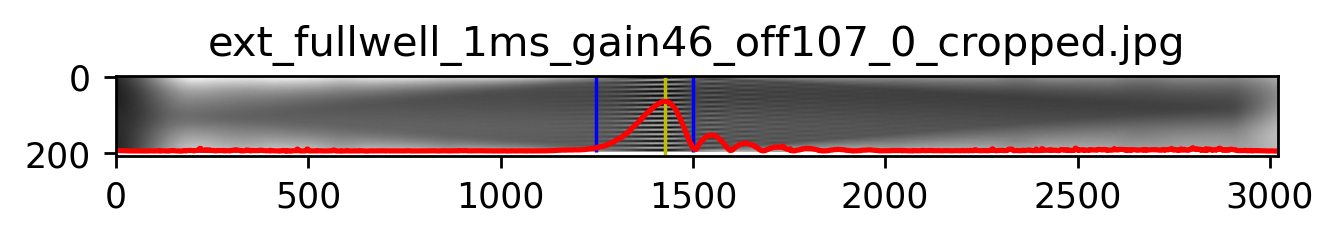

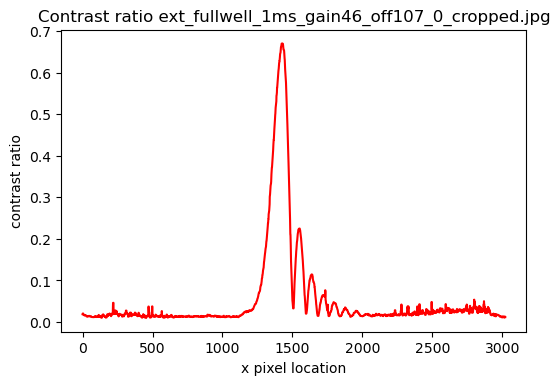

DOF in mm:  2.772602739726027
Total intensity:  12740.0


<ipython-input-6-a0290b216ffe>:6: RuntimeWarning: Mean of empty slice
  mean_max = np.nanmean(row[max_ins[0]])


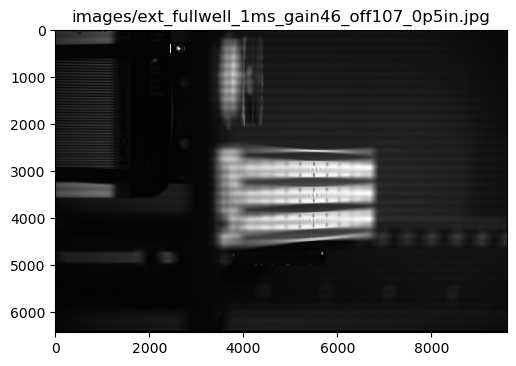

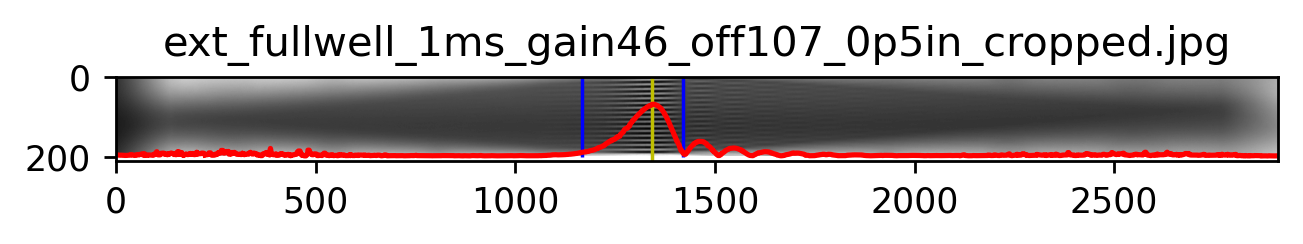

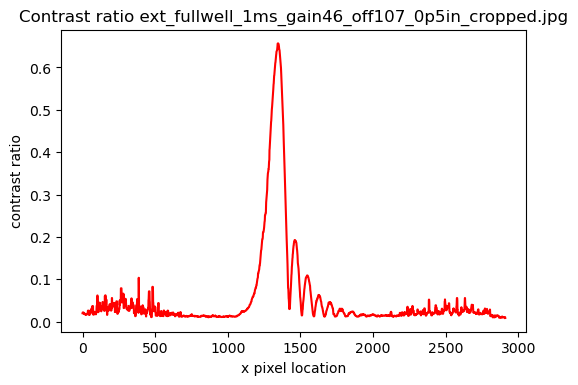

DOF in mm:  2.7616438356164377
Scaled total intensity:  14149.402


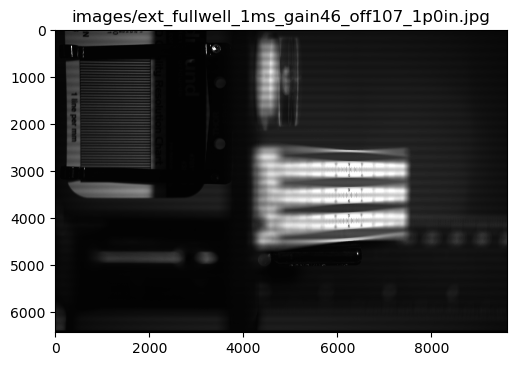

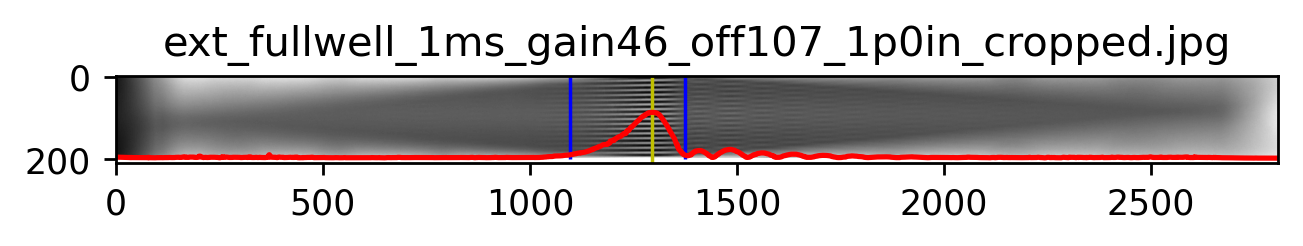

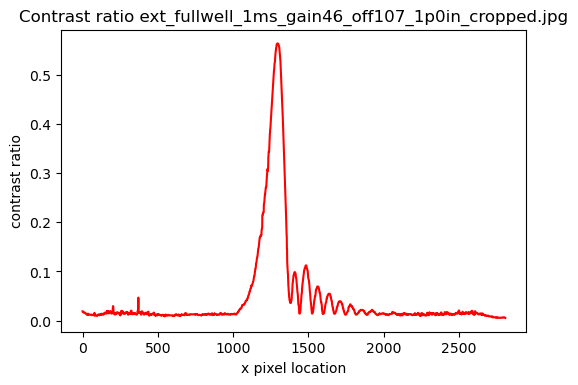

DOF in mm:  3.046575342465753
Scaled total intensity:  12025.671


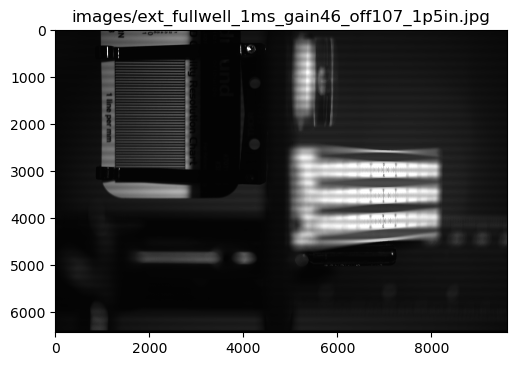

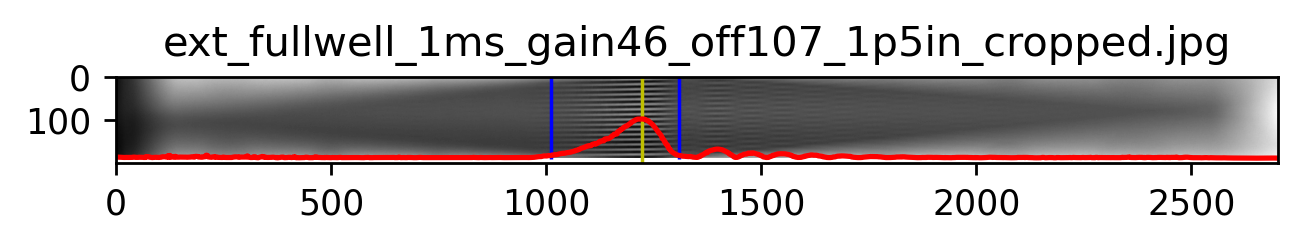

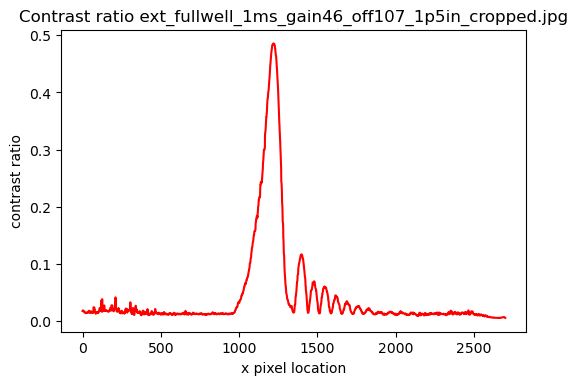

DOF in mm:  3.2438356164383557
Scaled total intensity:  9875.388


<ipython-input-6-a0290b216ffe>:6: RuntimeWarning: Mean of empty slice
  mean_max = np.nanmean(row[max_ins[0]])


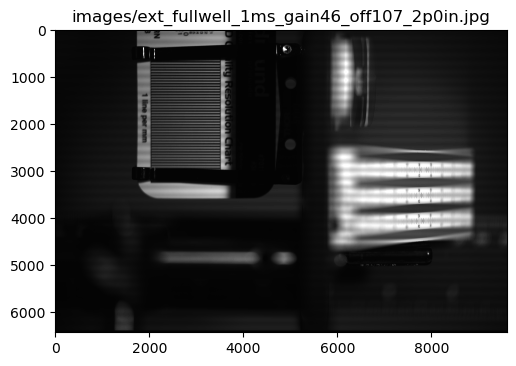

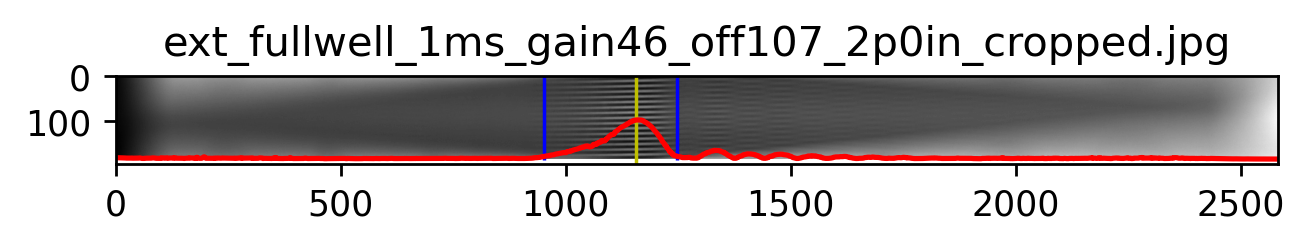

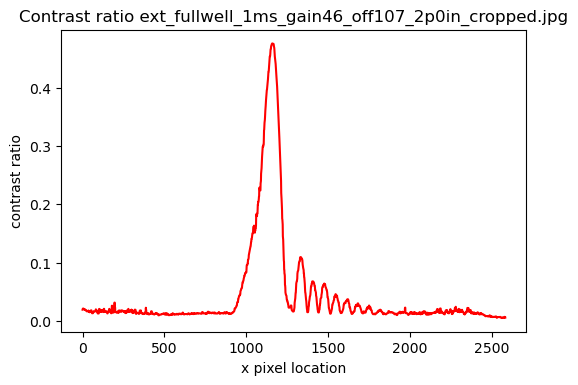

DOF in mm:  3.2438356164383557
Scaled total intensity:  9079.867


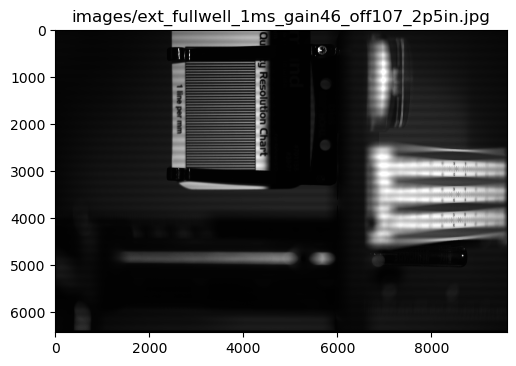

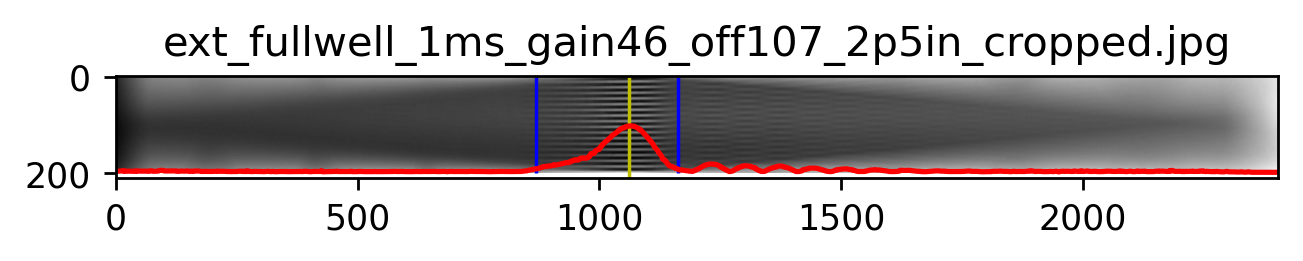

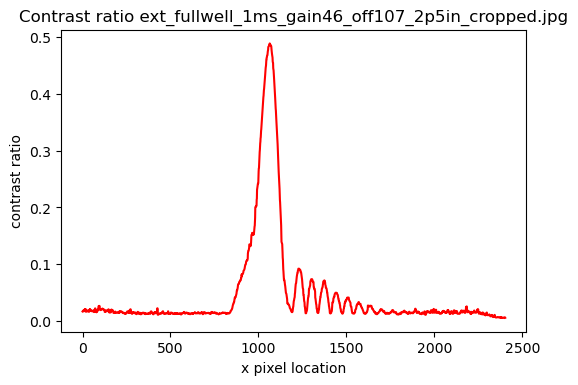

DOF in mm:  3.2219178082191777
Scaled total intensity:  9632.056


In [13]:
images = ['ext_fullwell_1ms_gain46_off107_0', 'ext_fullwell_1ms_gain46_off107_0p5in', 
         'ext_fullwell_1ms_gain46_off107_1p0in', 'ext_fullwell_1ms_gain46_off107_1p5in', 
         'ext_fullwell_1ms_gain46_off107_2p0in', 'ext_fullwell_1ms_gain46_off107_2p5in']
i = 0
for image_name in images:
    show_name = 'images/' + image_name + '.jpg'
    show_image = imageio.imread(show_name, as_gray=True)
    plt.figure(dpi=100)
    plt.title(show_name)
    plt.imshow(show_image, cmap='gray')
    cropped_name = image_name + '_cropped.jpg'
    if i == 0:
        light_collected0, max_ratio0 = calc_DOF(cropped_name, .08, .219, .0024, 6, False, 'DOF_image_overlay_.pdf')
        print("Total intensity: ", light_collected0)
    else:
        dof_ret = calc_DOF(cropped_name, .08, .219, .0024, 6, False, 'DOF_image_overlay_.pdf')
        light_collected = dof_ret[0] * (dof_ret[1] / max_ratio0)
        print("Scaled total intensity: ", light_collected)
    i += 1